## Logistic Regression Model

### Logistic Regression with Tf-Idf Vectorization

In [1]:
import pandas as pd
import numpy as np

In [2]:
# read data as pandas dataframe
data = pd.read_csv('../raw_data/fulltrain.csv', names=['label', 'text'])
data.head()

,label,text
0,1,"A little less than a decade ago, hockey fans w..."
1,1,The writers of the HBO series The Sopranos too...
2,1,Despite claims from the TV news outlet to offe...
3,1,After receiving 'subpar' service and experienc...
4,1,After watching his beloved Seattle Mariners pr...


In [3]:
# found out that fulltrain.csv has 202 duplicate rows => remove them before proceeding
data = data.drop_duplicates()

In [4]:
from collections import Counter
Counter(data['label'])

Counter({3: 17870, 1: 13911, 4: 9932, 2: 6939})

In [5]:
# create tf-idf matrix
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 1), max_features=10000) # HYPERPARAMETERS

In [6]:
from sklearn.model_selection import train_test_split

full_train_data = data.copy()
train_data, eval_data = train_test_split(full_train_data, test_size=0.2, random_state=42)
print(train_data.shape)
print(eval_data.shape)

(38921, 2)
(9731, 2)


In [7]:
X_train = vectorizer.fit_transform(train_data['text'])
X_eval = vectorizer.transform(eval_data['text'])

In [8]:
LABEL = 'label'
TEXT = 'text'

train_label = train_data[LABEL]
eval_label = eval_data[LABEL]

In [9]:
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
X_train_balanced, train_label_balanced = sm.fit_resample(X_train, train_label)

In [10]:
print("original training data:", Counter(full_train_data[LABEL]))
print("balanced training data:", Counter(train_label_balanced))
print("evaluation data:", Counter(eval_label))

original training data: Counter({3: 17870, 1: 13911, 4: 9932, 2: 6939})
balanced training data: Counter({4: 14276, 1: 14276, 2: 14276, 3: 14276})
evaluation data: Counter({3: 3594, 1: 2764, 4: 2007, 2: 1366})


In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

In [12]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_balanced, train_label_balanced)

LogisticRegression(max_iter=1000)

In [13]:
y_pred = model.predict(X_eval)

In [14]:
# print evaluation metrics
print('Accuracy: ', accuracy_score(eval_label, y_pred))
print('F1: ', f1_score(eval_label, y_pred, average='macro'))
print('Precision: ', precision_score(eval_label, y_pred, average='macro'))
print('Recall: ', recall_score(eval_label, y_pred, average='macro'))
print(classification_report(eval_label, y_pred))

Accuracy:  0.9610523070599116
F1:  0.9586741666106686
Precision:  0.9576758937382174
Recall:  0.95976250616417
              precision    recall  f1-score   support

           1       0.96      0.96      0.96      2764
           2       0.94      0.97      0.95      1366
           3       0.97      0.97      0.97      3594
           4       0.95      0.94      0.95      2007

    accuracy                           0.96      9731
   macro avg       0.96      0.96      0.96      9731
weighted avg       0.96      0.96      0.96      9731



### Tracking Evaluation Metrics on `X_eval` while Tuning Hyperparameters

- Attempt 1
    
    `ngram_range` = (1,1)

    `max_features` = 10000

    no SMOTE
    
    Accuracy:  0.9592672193224849
    
    F1:  0.9591777858793994
    
    Precision:  0.9595104433629937
    
    Recall:  0.9592672193224849

- Attempt 2
    
    `ngram_range` = (1,1)

    `max_features` = 10000

    SMOTE is performed

    Accuracy:  0.9610523070599116
    
    F1:  0.9586741666106686

    Precision:  0.9576758937382174

    Recall:  0.95976250616417

But this is because the training data is highly imbalanced. We **need** to use SMOTE to balance the data, assuming the test data is balanced.

Without SMOTE, we will get higher score on evaluation data (since it is also imblaanced), but much lower score on test data.

Something weird seems to be the case:

- Evaluation scores are TOO high, with and without SMOTE (~0.96)
- Test scores are much lower, with and without SMOTE (~0.73)

This makes me feel that the test data is somehow fundamentally different from the evaluation (and training) data.

In [15]:
# sanity check for test data
test_data = pd.read_csv('../raw_data/balancedtest.csv', names=['label', 'text'])
test_data.head()

,label,text
0,1,When so many actors seem content to churn out ...
1,1,In what football insiders are calling an unex...
2,1,In a freak accident following Game 3 of the N....
3,1,North Koreas official news agency announced to...
4,1,The former Alaska Governor Sarah Palin would b...


In [16]:
X_test = vectorizer.transform(test_data['text'])
test_label = test_data[LABEL]

In [18]:
test_pred = model.predict(X_test)
test_pred

array([1, 1, 1, ..., 4, 4, 4])

In [19]:
# print evaluation metrics for test data
print('Accuracy: ', accuracy_score(test_label, test_pred))
print('F1: ', f1_score(test_label, test_pred, average='macro'))
print('Precision: ', precision_score(test_label, test_pred, average='macro'))
print('Recall: ', recall_score(test_label, test_pred, average='macro'))
print(classification_report(test_label, test_pred))

Accuracy:  0.7383333333333333
F1:  0.7314550185745465
Precision:  0.7556497275574477
Recall:  0.7383333333333333
              precision    recall  f1-score   support

           1       0.86      0.75      0.80       750
           2       0.78      0.47      0.59       750
           3       0.61      0.80      0.69       750
           4       0.77      0.93      0.84       750

    accuracy                           0.74      3000
   macro avg       0.76      0.74      0.73      3000
weighted avg       0.76      0.74      0.73      3000



## Deep Dive into Logistic Regression

The goal of this deep dive is to figure out WHY the model performs so much worse on the test data compared to the evaluation data.

We aim to analyze:

- Which features does the model think are important?
- Does it give too much importance to named entities?
- We will carefully look at which sentences does the model misclassify, and hope to understand why.
- We will also look at the confusion matrix to see if the model is misclassifying a particular class more than others.

In [23]:
vocabulary = vectorizer.vocabulary_ # word: index
inverse_vocabulary = {v: k for k, v in vocabulary.items()} # index: word

For each sentence (document), we want to know which words the model is paying more attention to. We want to find the coefficients of the model for each word in the sentence.

In [28]:
coefficients = model.coef_[0]
word_coefficients = [(inverse_vocabulary[i], coefficients[i]) for i in range(len(coefficients))]

In [29]:
sorted_word_coefficients = sorted(word_coefficients, key=lambda x: abs(x[1]), reverse=True)

In [30]:
for word, coef in sorted_word_coefficients[:10]:
    print(word, coef)

said 11.789770600498269
monday 10.493140936872527
added 7.808309030055518
sources 6.280086168836419
reportedly 6.228156340523736
is -5.79658553888259
reporters 5.337395303158403
adding 5.268752055171852
press 5.060305398302445
tuesday 5.00712622084366


In [69]:
abuse_sources = [
    'Tuesday is a good day',
    'Wednesday is a good day',
    'Thursday is a good day',
    'Friday is a good day',
]
abuse_sources = model.predict(vectorizer.transform(abuse_sources))
abuse_sources

array([1, 4, 4, 4])

To us, it seems very strange that the model treats days so differently - it literally changes the class of a sentence depending on which day you're talking about. This is clearly not a good strategy. It's likely that "Tuesday" occurred most commonly in satirical sentences, and the model learnt to be cautious of sentences with the word "Tuesday".

In [31]:
# trump vs biden, WOW this is a big deal!
print(word_coefficients[vocabulary['trump']])
print(word_coefficients[vocabulary['biden']])

('trump', -2.7926064400737336)
('biden', 1.0761042814297563)


In [90]:
trump_biden_sentences = [
    'Trump is the best president.',
    'Biden is the best president.',
    'Trump was a president.',
]
trump_biden_predictions = model.predict(vectorizer.transform(trump_biden_sentences))
print(trump_biden_predictions)
trump_biden_probabilities = model.predict_proba(vectorizer.transform(trump_biden_sentences))
print(trump_biden_probabilities) # the model seems to be quite confident (>90%) when classifying a sentence with "Trump" to be a hoax.

[2 1 2]
[[7.80711833e-04 9.88918205e-01 8.41701297e-03 1.88406997e-03]
 [3.50058635e-01 3.14347460e-01 1.93982380e-01 1.41611525e-01]
 [2.10585576e-04 9.98785557e-01 8.54457056e-04 1.49400399e-04]]


The above result can be unsettling. The only difference between the two sentences is that I've replaced Trump with Biden, and the model proceeds to change it's classification from satire to hoax. At least we can take comfort knowing that it doesn't classify it as reliable :O

Moreover, the model seems to be quite confident (>90%) when classifying a sentence with "Trump" to be a hoax.

In [87]:
# some more pairs of weird words
print(word_coefficients[vocabulary['washington']])
print(word_coefficients[vocabulary['moscow']])
print(word_coefficients[vocabulary['china']])

city_sentences = [
    'Washington is a good place to work',
    'Moscow is a good place to work',
    'China is a good place to work',
]
vectorizer.transform(city_sentences)
city_predictions = model.predict(vectorizer.transform(city_sentences))
print(city_predictions)
city_probabilities = model.predict_proba(vectorizer.transform(city_sentences))
print(city_probabilities)

('washington', -0.9353711018296236)
('moscow', -0.5610157725122245)
('china', -1.5202119811401527)
[4 3 3]
[[0.15938078 0.17571529 0.28585642 0.37904751]
 [0.16840476 0.3102318  0.39468708 0.12667635]
 [0.09430206 0.16475032 0.5229113  0.21803632]]


The above example CLEARLY shows that the model is biased towards washington (possibly because the model was trained on a dataset where washington was a common word in reliable news articles). This is a clear example of bias in the model.

Of course, it doesn't mean that any sentence involving Washington automatically becomes more reliable than sentences involving China or Moscow.

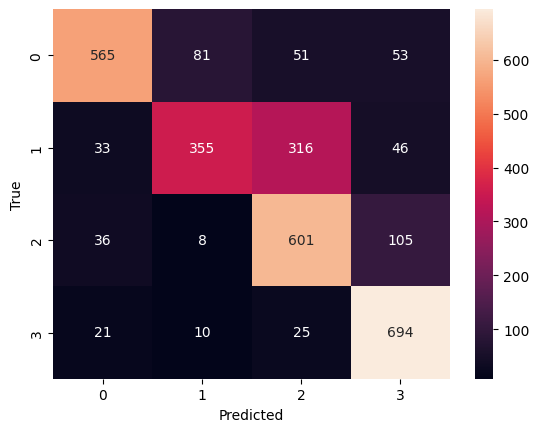

In [73]:
# we also want to figure out what the model is getting wrong, i.e., which class does it get most confused by
# for this, we can use a confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

conf_matrix = confusion_matrix(test_label, test_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

We can make the following observations from the above model:
- Even though the overall F1 score of the model is not very high (~0.70), it is able to classify the majority of the reliable news articles, as being reliable. This means we have a low false positive rate (it doesn't "catch" many reliable news articles as being unreliable)
- There are 2 main issues that the model faces: 
  - It classifies many hoax articles as being propaganda, but surprisingly, it doesn't classify many propaganda articles as being hoax.
  - It also classifies many propaganda articles as being reliable.

Honestly the second kind of issue is more worrisome. Because it fails to catch propaganda articles as being unreliable. This is a more dangerous issue. More generally speaking, propaganda articles tend to use authoritative language, and are more likely to be longer, making them sound more "convincing". This is also why humans find it difficult to distinguish between propaganda and reliable news articles.

It's not just humans though. It's been shown that the youtube recommendation algorithm also ranks more authoritative videos higher, even if they are spreading misinformation. This is a very difficult problem to solve, and it's not clear if we can solve it with a simple logistic regression model, or any algorithmic model for that matter.

There is no algorithm for truth.

#### Looking at which categories of sentences are actually misclassified

Are the most misclassified sentences from: health? environment? politics? etc.

In [74]:
# get the indices of all the test data that were misclassified
misclassified_indices = np.where(test_label != test_pred)[0]

# out of these, find the ones whose ground truth is 3 (propaganda), but the model predicted 4 (reliable)
misclassified_indices_3_4 = [i for i in misclassified_indices if test_label[i] == 3 and test_pred[i] == 4]

print(len(misclassified_indices_3_4))
# and then print those sentences
for i in misclassified_indices_3_4:
    print(test_data.iloc[i][TEXT])

105
 New research suggests that one of the more popular antidepressants, Paxil, may actually contribute to the growth of cancerous tumors in women. That's according to a team of scientists from the City of Hope in Duarte, California, which has developed a quick way to zero in on drugs and chemicals that are capable of disrupting human sex hormones and influencing the development and progression of diseases, like breast cancer in women. As reported by the Los Angeles Times : In a trial screening of 446 drugs in wide circulation, the new assay singled out the popular antidepressant paroxetine (better known by its commercial name, Paxil) as having a weak estrogenic effect that could promote the development and growth of breast tumors in women. The finding is important because as much as 25 percent of women who are under treatment for breast cancer suffer from depression, and that's a condition regularly treated with antidepressants known as selective serotonin reuptake inhibitors, or SSRI

Reading the sentences above, it's clear that nearly all of the 105 misclassified sentences are from the health industry (they discuss topics such as diets, food, medicine, etc.) and environment industry (they discuss topics such as climate change, pollution, etc.). This is a very interesting observation. It seems that the model is not able to distinguish between reliable and unreliable news articles in these industries. This makes some sense because the majority of the sentences in the dataset are from the politics industry, and so, the model is unable to generalize beyond the politics industry.

In fact, the model performs well only on sentences relating to _American_ (or Western) politics and business, not other countries. Again, unsurprising because the dataset is primarily on American politics and business.

In [86]:
vaccine_sentences = [
    'Vaccines are useful',
    'Vaccines are not useful',
]
vaccine_predictions = model.predict(vectorizer.transform(vaccine_sentences))
print(vaccine_predictions) # both are classified as propaganda
vaccine_probabilities = model.predict_proba(vectorizer.transform(vaccine_sentences))
vaccine_probabilities

[3 3]


array([[0.01691492, 0.05866533, 0.9129866 , 0.01143315],
       [0.00901312, 0.03801673, 0.94089802, 0.01207214]])

One interesting thing is the model is over 90% confident in its prediction, and is still wrong!